In [3]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
import logging

logging.disable(logging.WARNING)
warnings.filterwarnings("ignore")

In [4]:
class SimilarityDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe.dropna() 
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        score = self.data.iloc[idx][0]
        sentence1 = self.data.iloc[idx][1]
        sentence2 = self.data.iloc[idx][2]

        inputs = self.tokenizer.encode_plus(
            sentence1,
            sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'score': torch.tensor(score, dtype=torch.float)
        }


class BertSimilarityModel(nn.Module):
    def __init__(self, bert_model_name):
        super(BertSimilarityModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        similarity_score = self.linear(pooled_output)
        return similarity_score.squeeze(1)

train_data = pd.read_csv('Data/train.csv', sep='\t')
validation_data = pd.read_csv('Data/dev.csv', sep='\t')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = SimilarityDataset(train_data, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataset = SimilarityDataset(validation_data, tokenizer, max_length=128)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

model = BertSimilarityModel('bert-base-uncased')

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=3e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_losses = [] 
validation_losses = []  

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['score'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in validation_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['score'].to(device)

            outputs = model(input_ids, attention_mask)
            val_loss = criterion(outputs, targets)
            total_val_loss += val_loss.item()

    validation_losses.append(total_val_loss / len(validation_loader))

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {validation_losses[-1]}")



Epoch 1/10: 100%|██████████| 357/357 [18:54<00:00,  3.18s/it]


Epoch 1/10, Training Loss: 0.9842740468033889, Validation Loss: 0.5808929476239111


Epoch 2/10: 100%|██████████| 357/357 [18:09<00:00,  3.05s/it]


Epoch 2/10, Training Loss: 0.3941861468495107, Validation Loss: 0.6544419710078965


Epoch 3/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 3/10, Training Loss: 0.23090208919734515, Validation Loss: 0.5986251360129403


Epoch 4/10: 100%|██████████| 357/357 [17:44<00:00,  2.98s/it]


Epoch 4/10, Training Loss: 0.16176294992450907, Validation Loss: 0.547596998796191


Epoch 5/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 5/10, Training Loss: 0.11960359654423236, Validation Loss: 0.5391427112905227


Epoch 6/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 6/10, Training Loss: 0.08685108365005806, Validation Loss: 0.52721991835405


Epoch 7/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 7/10, Training Loss: 0.07117463495185812, Validation Loss: 0.6152850327932317


Epoch 8/10: 100%|██████████| 357/357 [17:42<00:00,  2.98s/it]


Epoch 8/10, Training Loss: 0.06732064673640564, Validation Loss: 0.5426283604262964


Epoch 9/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 9/10, Training Loss: 0.057975477716397675, Validation Loss: 0.5589669915726003


Epoch 10/10: 100%|██████████| 357/357 [17:43<00:00,  2.98s/it]


Epoch 10/10, Training Loss: 0.058895413088155726, Validation Loss: 0.5524155271604009


In [5]:
model.eval()
predicted_scores = []
true_scores = []

with torch.no_grad():
    for batch in tqdm(validation_loader, desc='Validation'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['score'].numpy() 

        outputs = model(input_ids, attention_mask)
        predicted_scores.extend(outputs.cpu().numpy())
        true_scores.extend(targets)

pearson_corr = np.corrcoef(predicted_scores, true_scores)[0, 1]

print("Pearson correlation coefficient:", pearson_corr)

Validation: 100%|██████████| 92/92 [01:26<00:00,  1.06it/s]

Pearson correlation coefficient: 0.8700755408169226


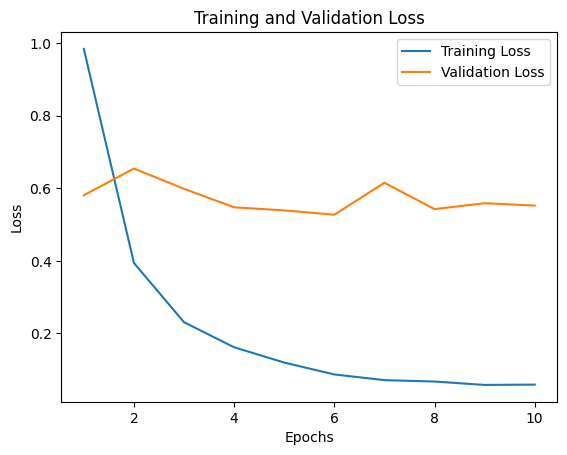

In [6]:
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

with open('bert_similarity_model.pkl', 'wb') as f:
    pickle.dump(model, f)